# Machine Learning with Adversaries: Byzantine Tolerant Gradient Descent
## Follow up


In [764]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [540]:
# http://yulijia.net/vistat/2013/03/gradient-descent-algorithm-with-r
def f1(X):
    x, y = X[0], X[1]
    return np.sin(x**2/2 - y**4/4 + 3)*np.cos(2*x + 1 - np.exp(y))

def df1(X):
    x, y = X[0], X[1]
    dx = ( x*np.cos(x**2/2 - y**4/4 + 3)*np.cos(2*x + 1 - np.exp(y)) 
        - 2*np.sin(x**2/2 - y**4/4 + 3)*np.sin(2*x + 1 - np.exp(y)))
    
    dy = ( -y**3*np.cos(x**2/2 - y**4/4 + 3)*np.cos(2*x + 1 - np.exp(y))
     + np.exp(y)*np.sin(x**2/2 - y**4/4 + 3)*np.sin(2*x + 1 - np.exp(y)))
    
    return np.array([dx,dy])


#https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
def eggholder(x):
     return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
             -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))


In [376]:
def norm2(X):
    return X[0]**2 + X[1]**2

def dnorm2(X):
    return np.array([2*X[0], 2*X[1]])

In [ ]:
class GAR:
    """ Base gradient aggregation rule class.
    """

    def __init__(self, nbworkers, nbbyzwrks):
        """ Unimplemented constructor.

        Args:
          nbworkers: Total number of workers
          nbbyzwrks: Declared number of Byzantine workers
        """
        raise NotImplementedError

    def aggregate(self, gradients):
        """ Build the gradient aggregation operation of the given gradients.

        Args:
          gradients: Computed gradient tensors

        Returns:
          Aggregated gradient tensor
        """
        raise NotImplementedError


In [800]:
class Median(GAR):
    
    def __init__(self, nbworkers, nbbyzwrks):
        self.nbworkers  = nbworkers
        self.nbbyzwrks  = nbbyzwrks
        self.nbselected = nbworkers - nbbyzwrks - 2 #number of selected gradients. Equivalent to batch size
        self.workers_status = [[True,0] for i in range(nbworkers)]
        self.nb_suspended = None
        self.suspension_time = None
        self.probability = None
        
    def aggregate(self, gradients):
        gradient = np.zeros(len(gradients[0]))
        for i in range(len(gradient)):
            grads_i = [gradients[j][i] for j in range(len(gradients))]
            med_i = np.median(grads_i)
            gradient[i] = med_i
        return gradient, None

In [817]:
class Average(GAR):
    
    def __init__(self, nbworkers, nbbyzwrks):
        self.nbworkers  = nbworkers
        self.nbbyzwrks  = nbbyzwrks
        self.nbselected = nbworkers - nbbyzwrks - 2 #number of selected gradients. Equivalent to batch size
        self.workers_status = [[True,0] for i in range(nbworkers)]
        self.nb_suspended = None
        self.suspension_time = None
        self.probability = None
        
    def aggregate(self, gradients):
        
        return np.mean(gradients, axis=0), None

In [802]:
class AverageSuspend(GAR):
    
    def __init__(self, nbworkers, nbbyzwrks, nb_suspended=None, suspension_time=None, probability=None):
        self.nbworkers  = nbworkers
        self.nbbyzwrks  = nbbyzwrks
        self.nbselected = nbworkers - nbbyzwrks - 2 #number of selected gradients. Equivalent to batch size
        self.workers_status = [[True,0] for i in range(nbworkers)]
        self.nb_suspended = nb_suspended
        self.suspension_time = suspension_time
        self.probability = probability
        
    def aggregate(self, gradients):
        """Aggregates the gradients, taking in consideration the active workers only.
        
        Args:
            gradients: List of submitted gradients, as numpy arrays
            active_workers: List of (boolean, int) of length nbworkers

        Output:
            gradient: aggregated gradient
            triplets: list of (gradient, score, worker_id) sorted by score
        """
        if self.nbselected == self.nbworkers:
            # Fast path average
            result = gradients[0]
            for i in range(1, self.nbworkers):
                result += gradients[i]
                result /= float(self.nbworkers)
            return result, None
        
        else:
            
            scores = [list() for i in range(self.nbworkers)]
            
            # Calculate distances
            for i in range(self.nbworkers - 1):
                score = scores[i]
                for j in range(i + 1, self.nbworkers):
                    # With: 0 <= i < j < nbworkers
                    distance = np.linalg.norm(gradients[i] - gradients[j])
                    if math.isnan(distance):
                        distance = math.inf
                    score.append(distance)
                    scores[j].append(distance)
            
            # Calculate scores
            nbinscore = self.nbworkers - self.nbbyzwrks - 2
            for i in range(self.nbworkers):
                score = scores[i]
                score.sort()
                scores[i] = sum(score[:nbinscore])
                
            # Return the average of the m gradients with the smallest score
            triplets = [(gradients[i], scores[i], i) for i in range(self.nbworkers)]
            triplets.sort(key=lambda triplet : triplet[1]) #triplets sorted by score
            
            result = np.zeros(len(gradients[0]))
            
            nbadded = 0#number of gradients to average
            for i in range(self.nbworkers):
                worker_id = triplets[i][2]
                if self.workers_status[worker_id][0]:    #if the worker is active, add the gradient
                    result += triplets[i][0]             
                    nbadded +=1
            result = result/float(nbadded)
            
            return result, triplets
        
    def update_workers_status(self, sorted_workers_ids): 
        """
        Updates workers status inplace. 

        Args:
            active_workers (list of (boolean, int)) : int=suspension time left
            sorted_workers_ids (list of ids, sorted by score). Ex for [3,0,1,2]: 1 and 2 have the highest scores
            nb_suspended (int)                    
            suspension_time (int)

        Returns:
            
            """

        if self.nb_suspended is None or self.nb_suspended == 0:
            return 

        else:
            if self.suspension_time is None:
                print('suspension_time must be a positive integer if nb_suspended is not None.')
                return

            else:
                #update suspension time left 
                #print('Updating suspension time left...')
                for i in range(self.nbworkers):
                
                    if not self.workers_status[i][0]: #if the worker is currently suspended
                        #print(i, ' currently suspended')
                        if self.workers_status[i][1] <= 1: #if the worker has 1 step left to be suspended
                            self.workers_status[i][0], self.workers_status[i][1] = True, 0 #the worker is not suspended anymore
                        else:
                            
                            self.workers_status[i][1] -= 1
                        #print(self.workers_status)
                
                #suspend the nb_suspended workers with the highest scores    
                #print('Suspending the workers with the highest scores...')
                for i in range(self.nb_suspended):
                    rank = self.nbworkers-i-1
                    worker_id = sorted_workers_ids[rank] #the worker to suspend. 
                                                         #The first to suspend is the last the sorted list
                    #self.workers_status[worker_id] = self.suspend(self.workers_status[worker_id], rank)
                    #print('worker_id: ', worker_id)
                    
                    self.workers_status[worker_id] = [False, self.suspension_time]
                    
                    #with probability:
                    self._suspend(self.workers_status[worker_id], rank)
                    
                    #print(self.workers_status)
                    
    def _suspend(self, single_worker_status, rank):
        '''
        Suspends a worker with a certain probability

        Args:
            single_worker_status ([bool,int])
            rank (int) : rank of the worker in the list sorted by score
        Returns:
            updated_status 
        '''
        probabilities = [None, 'inv', 'log']

        if self.probability not in probabilities:
            raise NameError("probability must be in [None, 'inv', 'log']")

        else:
            if self.probability == None:
                return [False, self.suspension_time]
            
            elif self.probability == 'inv':
                if np.random.binomial(1,1/(self.nbworkers-rank+1)):
                    return [False, self.suspension_time]
                else:
                    return single_worker_status
            
            elif self.probability == 'log':
                if np.random.binomial(1,1/np.log(self.nbworkers-rank+1)):
                    return [False, self.suspension_time]
                else:
                    return single_worker_status
        
    

In [803]:
class Krum(GAR):
    '''
    Multi-Krum aggregator class
    '''
    
    def __init__(self, nbworkers, nbbyzwrks, nb_suspended=None, suspension_time=None, probability=None):
        
        self.nbworkers  = nbworkers
        self.nbbyzwrks  = nbbyzwrks
        self.nbselected = nbworkers - nbbyzwrks - 2 #number of selected gradients. Equivalent to batch size
        self.workers_status = [[True,0] for i in range(nbworkers)]
        self.nb_suspended = nb_suspended
        self.suspension_time = suspension_time
        self.probability = probability
        
        
        
    def aggregate(self, gradients):
        """Aggregates the gradients, taking in consideration the active workers only.
        
        Args:
            gradients: List of submitted gradients, as numpy arrays
            active_workers: List of (boolean, int) of length nbworkers

        Output:
            gradient: aggregated gradient
            triplets: list of (gradient, score, worker_id) sorted by score
        """
        
        if self.nbselected == self.nbworkers:
            # Fast path average
            result = gradients[0]
            for i in range(1, self.nbworkers):
                result += gradients[i]
                result /= float(self.nbworkers)
            return result
        
        else:
            
            scores = [list() for i in range(self.nbworkers)]
            
            # Calculate distances
            for i in range(self.nbworkers - 1):
                score = scores[i]
                for j in range(i + 1, self.nbworkers):
                    # With: 0 <= i < j < nbworkers
                    distance = np.linalg.norm(gradients[i] - gradients[j])
                    if math.isnan(distance):
                        distance = math.inf
                    score.append(distance)
                    scores[j].append(distance)
            
            # Calculate scores
            nbinscore = self.nbworkers - self.nbbyzwrks - 2
            for i in range(self.nbworkers):
                score = scores[i]
                score.sort()
                scores[i] = sum(score[:nbinscore])
                
            # Return the average of the m gradients with the smallest score
            triplets = [(gradients[i], scores[i], i) for i in range(self.nbworkers)]
            triplets.sort(key=lambda triplet : triplet[1]) #triplets sorted by score
            
            result = np.zeros(len(gradients[0]))
            i, nbadded = 0, 0
            while nbadded <= self.nbselected and i < self.nbworkers:
                worker_id = triplets[i][2]
                if self.workers_status[worker_id][0]:    #if the worker is active
                    result += triplets[i][0]             #add the gradient
                    nbadded +=1
                i += 1
            result = result/float(nbadded)
            
            return result, triplets

    def update_workers_status(self, sorted_workers_ids): 
        """
        Updates workers status inplace. 

        Args:
            active_workers (list of (boolean, int)) : int=suspension time left
            sorted_workers_ids (list of ids, sorted by score). Ex for [3,0,1,2]: 1 and 2 have the highest scores
            nb_suspended (int)                    
            suspension_time (int)

        Returns:
            
            """

        if self.nb_suspended is None or self.nb_suspended == 0:
            return 

        else:
            if self.suspension_time is None:
                print('suspension_time must be a positive integer if nb_suspended is not None.')
                return

            else:
                #update suspension time left 
                #print('Updating suspension time left...')
                for i in range(self.nbworkers):
                
                    if not self.workers_status[i][0]: #if the worker is currently suspended
                        #print(i, ' currently suspended')
                        if self.workers_status[i][1] <= 1: #if the worker has 1 step left to be suspended
                            self.workers_status[i][0], self.workers_status[i][1] = True, 0 #the worker is not suspended anymore
                        else:
                            
                            self.workers_status[i][1] -= 1
                        #print(self.workers_status)
                
                #suspend the nb_suspended workers with the highest scores    
                #print('Suspending the workers with the highest scores...')
                for i in range(self.nb_suspended):
                    rank = self.nbworkers-i-1
                    worker_id = sorted_workers_ids[rank] #the worker to suspend. 
                                                         #The first to suspend is the last the sorted list
                    #self.workers_status[worker_id] = self.suspend(self.workers_status[worker_id], rank)
                    #print('worker_id: ', worker_id)
                    
                    self.workers_status[worker_id] = [False, self.suspension_time]
                    
                    #with probability:
                    self._suspend(self.workers_status[worker_id], rank)
                    
                    #print(self.workers_status)
                    
    def _suspend(self, single_worker_status, rank):
        '''
        Suspends a worker with a certain probability

        Args:
            single_worker_status ([bool,int])
            rank (int) : rank of the worker in the list sorted by score
        Returns:
            updated_status 
        '''
        probabilities = [None, 'inv', 'log']

        if self.probability not in probabilities:
            raise NameError("probability must be in [None, 'inv', 'log']")

        else:
            if self.probability == None:
                return [False, self.suspension_time]
            
            elif self.probability == 'inv':
                if np.random.binomial(1,1/(self.nbworkers-rank+1)):
                    return [False, self.suspension_time]
                else:
                    return single_worker_status
            
            elif self.probability == 'log':
                if np.random.binomial(1,1/np.log(self.nbworkers-rank+1)):
                    return [False, self.suspension_time]
                else:
                    return single_worker_status
        


In [1269]:
class Workers():
    '''
    Workers class
    Note on the strategy:
        dict with keys 'name' and 'parameters'
    '''
    
    
    def __init__(self, nbworkers, nbbyzwrks, strategy):
        '''
        Args:
            nbworkers
            nbbyzwrks
            strategy (dict): the strategy adopted by byzantine workers
        '''
        
        self.nbworkers  = nbworkers
        self.nbbyzwrks  = nbbyzwrks
        self.strategy = strategy
        
    def compute_gradients(self, f, df, X):
        nbcrtwrks = self.nbworkers - self.nbbyzwrks #nb of correct workers
        gradients = list()
        correct_grad = df(X)
        
        noise = np.random.normal(0,.2,[nbcrtwrks, 2])
        
        #correct gradients
        for i in range(nbcrtwrks): 
            gradients.append(correct_grad + noise[i])
       
        #byzantine gradients
    
        if self.strategy['name'] == 'binom':
            p = strategy['params']
            
            for i in range(nbbyzwrks):
                binom = np.random.binomial(1,p)
                if binom:
                    #m = np.random.normal(0,3,2)
                    #byz_gradient =
                    byz_gradient = -2*correct_grad +  5*np.random.normal([.1,.1],2,2)
                else:
                    byz_gradient = correct_grad + np.random.normal(0,.1,2)
                gradients.append(byz_gradient)
            return gradients
        
        

In [1270]:
class Optimizer():
    
    def __init__(self, aggregator, workers, lr=0.05, max_steps=100):
        self.aggregator = aggregator
        self.workers = workers
        self.lr = lr
        self.max_steps = max_steps
        
        
    def sgd_dim2(self, f, df):
        
        gradients_history, triplets_history, values = list(), list(), list()
        X = [.1,0]
        for idx in tqdm(range(max_steps)):
            
            #update the weights
            gradients = self.workers.compute_gradients(f, df, X)
            agg_gradient, triplets = self.aggregator.aggregate(gradients) #reminder: aggregate returns (result, triplets)
            X = X - lr*agg_gradient
            
            #save gradients, triplets and values in memory
            gradients_history.append(agg_gradient)
            triplets_history.append(triplets)
            values.append([X, f(X)])
            #print('[Step ', idx, ']')
            #print('   X    = ', X)
            #print('   f(X) = ', f(X))
            
            #update suspension status for workers
            if aggregator.nb_suspended is not None and aggregator.nb_suspended>0:
                sorted_workers_ids = [triplets[i][2] for i in range(len(triplets))]
                aggregator.update_workers_status(sorted_workers_ids)
                
        return gradients_history, triplets_history, values
    
    

In [1278]:
nbworkers = 50
nbbyzwrks = 20
lr=.01
max_steps=400
strategy = {'name':'binom', 'params':.8}
nb_sus = 30
sus_time = 2
prob = 'inv'

#initialize workers
workers = Workers(nbworkers, nbbyzwrks, strategy)


#average without suspension
aggregator = Average(nbworkers, nbbyzwrks)
optimizer = Optimizer(aggregator, workers, lr, max_steps)
grads_hist_avg, triplets_hist_avg, values_avg = optimizer.sgd_dim2(f1, df1)

#average with suspension
aggregator = AverageSuspend(nbworkers, nbbyzwrks, nb_suspended=nb_sus, suspension_time=sus_time, probability=prob)
optimizer = Optimizer(aggregator, workers, lr, max_steps)
grads_hist_avg_sus, triplets_hist_avg_sus, values_avg_sus = optimizer.sgd_dim2(f1, df1)

#median
aggregator = Median(nbworkers, nbbyzwrks)
optimizer = Optimizer(aggregator, workers, lr, max_steps)
grads_hist_med, triplets_hist_med, values_med = optimizer.sgd_dim2(f1, df1)

#MultiKrum without suspension
aggregator = Krum(nbworkers, nbbyzwrks, nb_suspended=None, suspension_time=None, probability=None)
optimizer = Optimizer(aggregator, workers, lr, max_steps)
grads_hist_krum, triplets_hist_krum, values_krum = optimizer.sgd_dim2(f1, df1)

#MultiKrum with suspension
aggregator = Krum(nbworkers, nbbyzwrks, nb_suspended=nb_sus, suspension_time=sus_time, probability=prob)
optimizer = Optimizer(aggregator, workers, lr, max_steps)
grads_hist_krum_sus, triplets_hist_krum_sus, values_krum_sus = optimizer.sgd_dim2(f1, df1)


100%|██████████| 400/400 [00:04<00:00, 95.95it/s] 


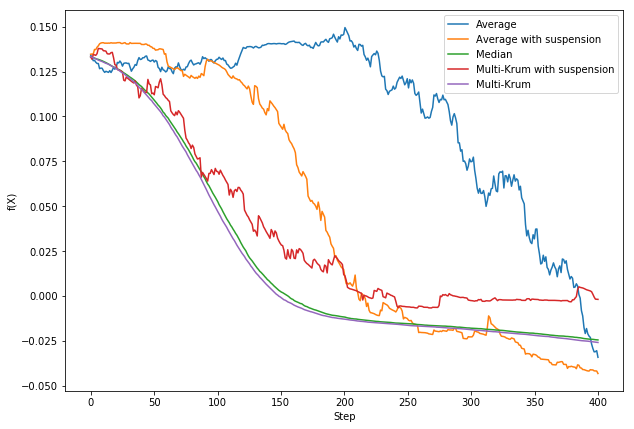

In [1279]:
begin = 0

y_avg = [values_avg[i][1] for i in range(begin, len(values_avg))]
X_avg = np.linspace(begin, len(values_avg), len(values_avg)-begin)

y_avg_sus = [values_avg_sus[i][1] for i in range(begin, len(values_avg_sus))]
X_avg_sus = np.linspace(begin, len(values_avg_sus), len(values_avg_sus)-begin)

y_med = [values_med[i][1] for i in range(begin, len(values_med))]
X_med = np.linspace(begin, len(values_med), len(values_med)-begin)

y_krum = [values_krum[i][1] for i in range(begin, len(values_krum))]
X_krum = np.linspace(begin, len(values_krum), len(values_krum)-begin)

y_krum_sus = [values_krum_sus[i][1] for i in range(begin, len(values_krum_sus))]
X_krum_sus = np.linspace(begin, len(values_krum_sus), len(values_krum_sus)-begin)

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.plot(X_avg, y_avg, label='Average')
ax.plot(X_avg_sus, y_avg_sus, label='Average with suspension')
ax.plot(X_med, y_med, label='Median')
ax.plot(X_krum_sus, y_krum_sus, label='Multi-Krum with suspension')
ax.plot(X_krum, y_krum, label='Multi-Krum')
ax.set_xlabel('Step')
ax.set_ylabel('f(X)')
ax.legend()
plt.savefig('kgraph_{}_{}_1_{}_{}'.format(nbworkers, nbbyzwrks, nb_sus, sus_time), dpi=200)
plt.show()



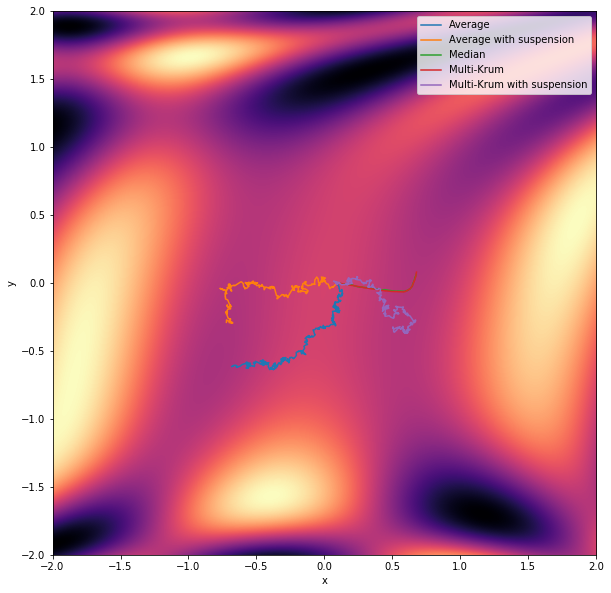

In [1281]:
#plot the function and the X trajectory

hw = 2   #half width
x = np.linspace(-hw, hw, 400)
y = np.linspace(-hw, hw, 400)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])
z = f1(xy)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
im = ax.imshow(z, interpolation='bilinear', origin='lower', cmap='magma', extent=[-hw,hw,-hw,hw])

#average
x_avg = [values_avg[i][0][0] for i in range(len(values_avg))]
y_avg = [values_avg[i][0][1] for i in range(len(values_avg))]
ax.plot(x_avg, y_avg, label = 'Average')

#average with suspension
x_avg_sus = [values_avg_sus[i][0][0] for i in range(len(values_avg_sus))]
y_avg_sus = [values_avg_sus[i][0][1] for i in range(len(values_avg_sus))]
ax.plot(x_avg_sus, y_avg_sus, label = 'Average with suspension')

#median
x_med = [values_med[i][0][0] for i in range(len(values_med))]
y_med = [values_med[i][0][1] for i in range(len(values_med))]
ax.plot(x_med, y_med, label = 'Median')

#multi_krum
x_krum = [values_krum[i][0][0] for i in range(len(values_krum))]
y_krum = [values_krum[i][0][1] for i in range(len(values_krum))]
ax.plot(x_krum, y_krum, label = 'Multi-Krum')

#multi_krum with suspension
x_krum_sus = [values_krum_sus[i][0][0] for i in range(len(values_krum_sus))]
y_krum_sus = [values_krum_sus[i][0][1] for i in range(len(values_krum_sus))]
ax.plot(x_krum_sus, y_krum_sus, label='Multi-Krum with suspension')

ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.pcolor(x, y, z)
#plt.colorbar()
ax.legend()

plt.savefig('kmap_{}_{}_1_{}_{}'.format(nbworkers, nbbyzwrks, nb_sus, sus_time), dpi=200)
plt.show()

In [1277]:

def test_update_workers_status(aggregator):
    '''Tests the update_workers_status method in the deterministic case.
    '''
    
    if aggregator.probability is not None:
        print('aggregator.probability should be None to run the test.')
        return
    else:
        aggregator.workers_status = [[True, 0], [False, 3], [True, 0], [False, 2], [False, 1], [False, 3]]
        aggregator.nb_suspended=2 
        aggregator.suspension_time=2

        sorted_workers_ids = [2,5,1,0,3,4]
        aggregator.update_workers_status(sorted_workers_ids)
        expected_output = [[True, 0], [False, 2], [True, 0], [False, 2], [False, 2], [False, 2]]
        output = aggregator.workers_status
        print('act_output: ', output)
        print('exp_output: ', expected_output)
        print(output==expected_output)


        sorted_workers_ids = [5,3,1,0,2,4]
        aggregator.update_workers_status(sorted_workers_ids)
        expected_output = [[True, 0], [False, 1], [False, 2], [False, 1], [False, 2], [False, 1]]
        output = aggregator.workers_status
        print('act_output: ', output)
        print('exp_output: ', expected_output)
        print(output==expected_output)

        sorted_workers_ids = [1,3,4,2,0,5]
        aggregator.update_workers_status(sorted_workers_ids)
        expected_output = [[False, 2], [True, 0], [False, 1], [True, 0], [False, 1], [False, 2]]
        output = aggregator.workers_status
        print('act_output: ', output)
        print('exp_output: ', expected_output)
        print(output==expected_output)

In [317]:
aggregator = Krum(5,2)
test_update_workers_status(aggregator)

act_output:  [[True, 0], [False, 2], [True, 0], [False, 2], [False, 2], [False, 2]]
exp_output:  [[True, 0], [False, 2], [True, 0], [False, 2], [False, 2], [False, 2]]
True
act_output:  [[True, 0], [False, 1], [False, 2], [False, 1], [False, 2], [False, 1]]
exp_output:  [[True, 0], [False, 1], [False, 2], [False, 1], [False, 2], [False, 1]]
True
act_output:  [[False, 2], [True, 0], [False, 1], [True, 0], [False, 1], [False, 2]]
exp_output:  [[False, 2], [True, 0], [False, 1], [True, 0], [False, 1], [False, 2]]
True
